In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [27]:
import h5py
import numpy as np
from astropy.units import deg
from lenstools import GaussianNoiseGenerator, ConvergenceMap

I want to study the global property of the clone dsets that I made. Specifically, 
* Power spectra
* Peak counts
* General pixel counts

I also want to see if these have any trends with cosmology, esp compared to the original maps. 

In [28]:
def count_peaks(im, size = 1):
    # i don't know if there's a faster way to do this but alas
    peak_idxs = np.zeros_like(im, dtype = bool)
    for i in range(size, im.shape[0]-size):
        for j in range(size, im.shape[1]-size): # no peaks on the boundaries i declare
            block = im[i-size:i+size+1, j-size:j+size+1].flatten()
            if np.all(im[i,j] >= block):
                peak_idxs[i,j] = True
    return im[peak_idxs]

In [29]:
def image_ps(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.powerSpectrum(l)

    return psd1D#/psd1D[0]

In [30]:
def image_bs(image):
    l = np.linspace(128, 128**2, 180)
    cmap = ConvergenceMap(image, angle=4*deg)
    _, psd1D = cmap.bispectrum(l)

    return psd1D#/psd1D[0]

In [31]:
def image_pc(image):
    #image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=4*deg)
    thresholds = np.arange(0.1, 0.3 ,0.001)
    #thresholds = np.linspace(-5, 5, 200)
    nu,peaks = cmap.peakCount(thresholds, norm=False)
    return peaks#/psd1D[0]

In [32]:
def image_pdf(image):
    image = (image-image.mean())/image.std()
    cmap = ConvergenceMap(image, angle=4*deg)
    #thresholds = np.arange(0.1, 0.3 ,0.001)
    thresholds = np.linspace(-5, 5, 200)
    _,pdf = cmap.pdf(thresholds, norm=True)
    return pdf#/psd1D[0]

In [33]:
orig_fname = '/home/users/swmclau2/oak/Uatu/UatuLightconeTraining/UatuLightconeTraining.hdf5'
grf_fname = '/home/users/swmclau2/oak/Uatu/UatuLightconeTraining/UatuLightconeTrainingGRF_smooth0.0.hdf5'
clone_fname = '/home/users/swmclau2/oak/Uatu/UatuLightconeTraining/UatuLightconeTrainingRobustifyDeepResnetAdvGRF.hdf5'

In [34]:
def plot_set(orig_fname, grf_fname, clone_fname, boxno, idx):
    fig = plt.figure(figsize=(18,6))
    with h5py.File(orig_fname, 'r') as f:
        mean, std = f.attrs['mean'], f.attrs['std']
        X1 = f[boxno]['X'][idx, :].squeeze()
        X1 = (X1-mean)/std
        
        
    with h5py.File(grf_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X2 = f[boxno]['X'][idx, :].squeeze()
        #X2 = (X2-mean)/std
        
    with h5py.File(clone_fname, 'r') as f:
        #mean, std = f.attrs['mean'], f.attrs['std']
        X3 = f[boxno]['X'][idx, :].squeeze()
        #X2 = (X2-mean)/std

    plt.subplot(131)
    plt.imshow(X1)
    plt.subplot(132)
    plt.imshow(X2)
    plt.subplot(133)
    plt.imshow(X3)
    plt.show()

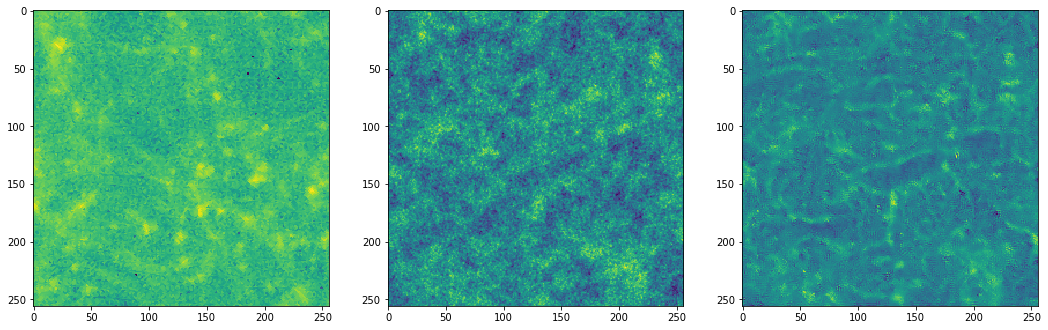

In [35]:
xt = plot_set(orig_fname,grf_fname, clone_fname, 'Box100', 32)

In [36]:
def compute_all_ps(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]

        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_ps = np.zeros((289, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_ps(x)
            
    return all_ps

In [37]:
def compute_all_bs(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_ps = np.zeros((289, 179))
        for i, x in enumerate(X):
            all_ps[i] = image_bs(x)
            
    return all_ps

In [38]:
def compute_all_pc(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]

        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_pc = np.zeros((289, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pc(x)
            
    return all_pc

note, should just make a generic function that applies some generic function of a cmap

In [39]:
def compute_all_pdf(fname, boxno, normalize= True):
    with h5py.File(fname, 'r') as f:
        X = f[boxno]['X'][()].squeeze()#, f[boxno]['Y'][0,:]
        if normalize:
            mean, std = f.attrs['mean'], f.attrs['std']
            X = (X-mean)/std
            
        all_pc = np.zeros((289, 199))
        for i, x in enumerate(X):
            all_pc[i] = image_pdf(x)
            
    return all_pc

In [40]:
orig_ps = compute_all_ps(orig_fname, 'Box010')
clone_ps = compute_all_ps(clone_fname, 'Box010', normalize = False)

In [41]:
orig_pc = compute_all_pc(orig_fname, 'Box010')
clone_pc = compute_all_pc(clone_fname, 'Box010', normalize = False)

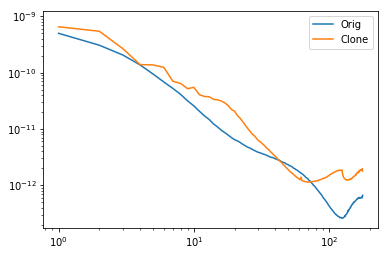

In [42]:
plt.plot(orig_ps.mean(axis=0), label = 'Orig')
plt.plot(clone_ps.mean(axis=0), label = 'Clone')
plt.legend(loc='best')
plt.loglog();

In [43]:
from time import time

In [44]:
l = np.linspace(128, 128*128, 180)
l2 = (l[1:]+l[:-1])/2.0
gen = GaussianNoiseGenerator(shape=(256,256),side_angle = 4 * deg)
grfs = np.zeros((289, 256, 256))
for i in xrange(289):
    gaussian_map = gen.fromConvPower(np.array([l2,orig_ps.mean(axis=0)]),seed = int(time()+i),bounds_error=False,fill_value=0.0)
    grfs[i] = gaussian_map.data

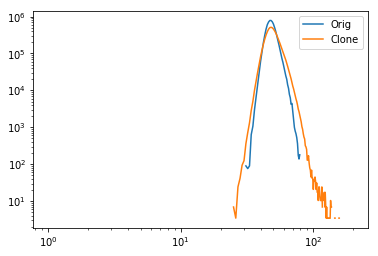

In [45]:
plt.plot(orig_pc.mean(axis=0), label = 'Orig')
plt.plot(clone_pc.mean(axis=0), label = 'Clone')
plt.legend(loc='best')
plt.loglog();

In [46]:
N = 200
all_orig_ps = np.zeros((N, 289, 179))
all_grf_ps = np.zeros((N, 289, 179))
all_clone_ps = np.zeros((N, 289, 179))

all_orig_pc = np.zeros((N, 289, 199))
all_grf_pc = np.zeros((N, 289, 199))
all_clone_pc = np.zeros((N, 289, 199))

all_orig_pdf = np.zeros((N, 289, 199))
all_grf_pdf = np.zeros((N, 289, 199))
all_clone_pdf = np.zeros((N, 289, 199))

all_ys = np.zeros((N, 2))
for boxno in xrange(N):
    print boxno
    boxname = 'Box%03d'%boxno
    with h5py.File(orig_fname, 'r') as f:
        y = f[boxname]['Y'][0,:]
        
    all_ys[boxno] = y.squeeze()
    #plot_pair(orig_fname, clone_fname, boxname, 128)
    
    orig_ps = compute_all_ps(orig_fname, boxname)
    grf_ps = compute_all_ps(grf_fname, boxname, normalize = False)
    clone_ps = compute_all_ps(clone_fname, boxname, normalize = False)
    
    all_orig_ps[boxno] = orig_ps
    all_grf_ps[boxno] = grf_ps
    all_clone_ps[boxno] = clone_ps
    
    orig_pc = compute_all_pc(orig_fname, boxname, normalize=True)
    grf_pc = compute_all_pc(grf_fname, boxname, normalize=False)
    clone_pc = compute_all_pc(clone_fname, boxname, normalize = False)
    
    all_orig_pc[boxno] = orig_pc
    all_grf_pc[boxno] = grf_pc
    all_clone_pc[boxno] = clone_pc
    
    orig_pdf = compute_all_pdf(orig_fname, boxname)
    grf_pdf = compute_all_pdf(grf_fname, boxname, normalize=False)
    clone_pdf = compute_all_pdf(clone_fname, boxname, normalize = False)
    
    all_orig_pdf[boxno] = orig_pdf
    all_grf_pdf[boxno] = grf_pdf
    all_clone_pdf[boxno] = clone_pdf
    
    #fig = plt.figure(figsize = (12,6))
    #plt.subplot(121)
    #plt.plot(orig_ps.mean(axis=0), label = 'Orig')
    #plt.plot(clone_ps.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    #plt.subplot(122)
    #plt.plot(orig_pc.mean(axis=0), label = 'Orig')
    #plt.plot(clone_pc.mean(axis=0), label = 'Clone')
    #plt.legend(loc='best')
    #plt.loglog();
    
    #plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [47]:
sorted_y_idxs = np.argsort(all_ys[:,0])
#sorted_y_idxs = np.argsort(all_ys[:,1])

In [48]:
cmap = sns.cubehelix_palette(N, start=2, rot=0, dark=0.1, light=.95)

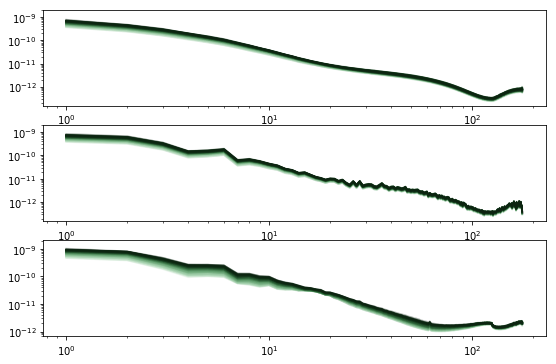

In [74]:
fig = plt.figure(figsize = (9,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    plt.subplot(311)
    plt.plot(all_orig_ps[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.3)
    plt.subplot(312)
    plt.plot(all_grf_ps[i].mean(axis = 0), c = c, alpha = 0.3)
    plt.subplot(313)
    plt.plot(all_clone_ps[i].mean(axis = 0), c = c, alpha = 0.3)

#plt.legend(loc='best')
for i in xrange(3):
    plt.subplot(3,1,i+1)
    plt.loglog()
    #plt.xlim([-2,3]);
#plt.yscale('log');

In [75]:
#nu_ = np.linspace(-5, 5, 200)
nu_ =  thresholds = np.arange(0.1, 0.3 ,0.001)

nu = (nu_[1:] + nu_[:-1])/2.0

In [76]:
grf_pcs = np.zeros((289, 199))
grf_pdfs = np.zeros((289,199))
for i, im in enumerate(grfs):
    pc = image_pc(im)
    grf_pcs[i] = pc
    
    pdf = image_pdf(im)
    grf_pdfs[i] = pdf

In [77]:
rand_images = np.random.randn(289, 256, 256)
rand_pcs = np.zeros((289, 199))
rand_pdfs = np.zeros((289,199))

for i, im in enumerate(rand_images):
    pc = image_pc(im)
    rand_pcs[i] = pc
    pdf = image_pdf(im)
    rand_pdfs[i] = pdf

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


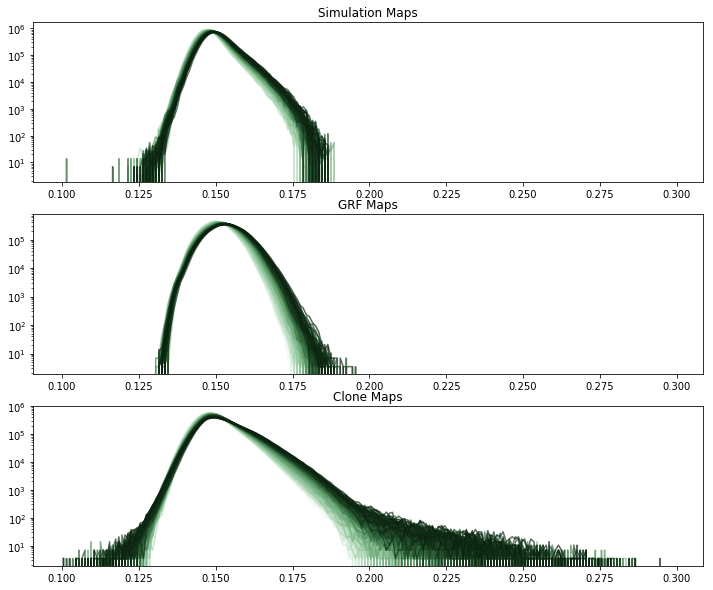

In [101]:
fig = plt.figure(figsize = (12,10))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    plt.subplot(311)
    plt.title('Simulation Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    plt.subplot(312)
    plt.title('GRF Maps')
    plt.plot(nu, all_grf_pc[i].mean(axis = 0), c = c, alpha = 0.7)
    plt.subplot(313)
    plt.title('Clone Maps')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7)
    
plt.legend(loc='best')
for i in xrange(3):
    plt.subplot(3,1,i+1)
    #plt.xlim([-5,5]);
    plt.yscale('log');

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


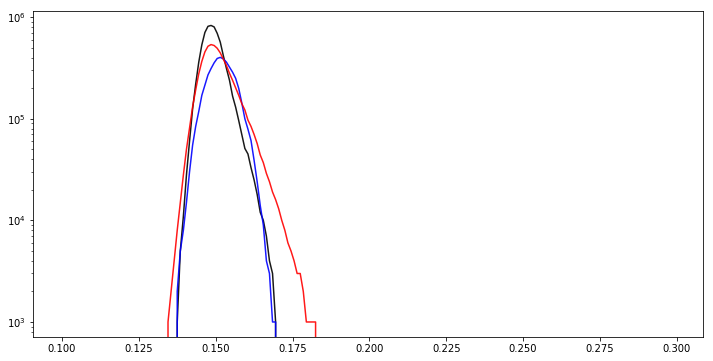

In [122]:
fig = plt.figure(figsize = (12,6))
idx = 60
c = 'k'
i = sorted_y_idxs[idx]
#plt.subplot(311)
#plt.title('Simulation Maps')
plt.plot(nu, np.median(all_orig_pc[i], axis=0), c = c, alpha = 0.9)
#plt.subplot(312)
#plt.title('GRF Maps')
plt.plot(nu, np.median(all_grf_pc[i], axis=0), c = 'b', alpha = 0.9)
#plt.subplot(313)
#plt.title('Clone Maps')

plt.plot(nu, np.median(all_clone_pc[i], axis=0), c = 'r', alpha = 0.9)
    
plt.legend(loc='best')
#for i in xrange(3):
    #plt.subplot(3,1,i+1)
    #plt.xlim([-5,5]);
plt.yscale('log');

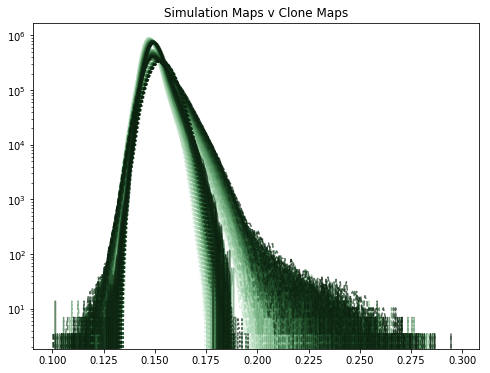

In [79]:
fig = plt.figure(figsize = (8,6))

for idx, c in enumerate(cmap):
    i = sorted_y_idxs[idx]
    #plt.subplot(311)
    plt.title('Simulation Maps v Clone Maps')
    plt.plot(nu, all_orig_pc[i].mean(axis = 0), c = c, label = r'$\Omega_m=%0.2f$'%all_ys[i,0], alpha = 0.7)
    #plt.subplot(312)
    #plt.title('Clone Maps')
    plt.plot(nu, all_grf_pc[i].mean(axis=0), c=c, alpha = 0.7, ls = ':')
    plt.plot(nu, all_clone_pc[i].mean(axis = 0), c = c, alpha = 0.7, ls = '--')
    
#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0))

#plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-5,5]);
plt.yscale('log');

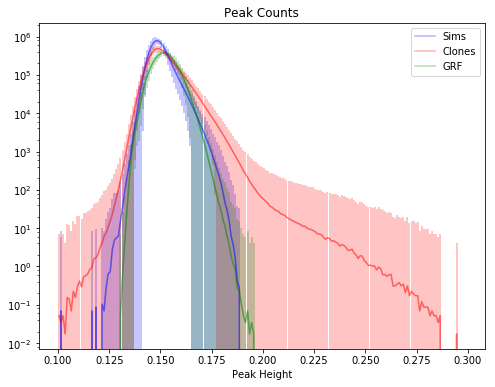

In [80]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, all_orig_pc.mean(axis = (0,1)), label = 'Sims', alpha = 0.3, color = 'b')

plt.errorbar(nu, all_orig_pc.mean(axis = (0,1)), yerr = all_orig_pc.std(axis = (0,1)), alpha = 0.3, color = 'b')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_clone_pc.mean(axis = (0,1)), label = 'Clones', alpha = 0.3, color = 'r')

plt.errorbar(nu, all_clone_pc.mean(axis = (0,1)),yerr = all_clone_pc.std(axis = (0,1)), alpha = 0.3, color = 'r')

plt.plot(nu, all_grf_pc.mean(axis = (0,1)), label = 'GRF', alpha = 0.3, color = 'g')

plt.errorbar(nu, all_grf_pc.mean(axis = (0,1)),yerr = all_grf_pc.std(axis = (0,1)), alpha = 0.3, color = 'g')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
#plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak Height')

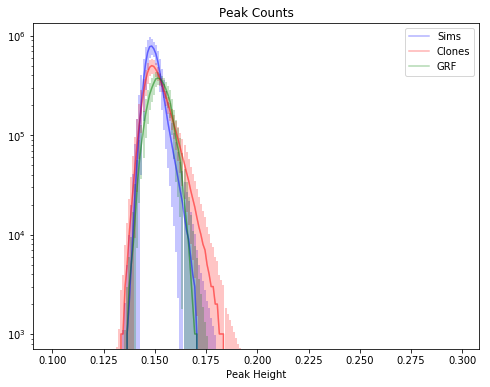

In [123]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('Peak Counts')
plt.plot(nu, np.median(all_orig_pc, axis = (0,1)), label = 'Sims', alpha = 0.3, color = 'b')

plt.errorbar(nu, np.median(all_orig_pc,axis = (0,1)), yerr = all_orig_pc.std(axis = (0,1)), alpha = 0.3, color = 'b')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, np.median(all_clone_pc,axis = (0,1)), label = 'Clones', alpha = 0.3, color = 'r')

plt.errorbar(nu, np.median(all_clone_pc, axis = (0,1)),yerr = all_clone_pc.std(axis = (0,1)), alpha = 0.3, color = 'r')

plt.plot(nu, np.median(all_grf_pc, axis = (0,1)), label = 'GRF', alpha = 0.3, color = 'g')

plt.errorbar(nu, np.median(all_grf_pc, axis = (0,1)),yerr = all_grf_pc.std(axis = (0,1)), alpha = 0.3, color = 'g')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pcs.mean(axis = 0), label = 'GRF')
#plt.plot(nu, rand_pcs.mean(axis = 0), label = 'Random')

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
plt.yscale('log');
plt.xlabel(r'Peak Height')

K-s test of these 2 dists

In [81]:
def ks_statistic(dist1, dist2):
    n,m = len(dist1), len(dist2)
    c = 1.358
    threshold = c*np.sqrt((n+m)*1.0/(n*m))
    d= np.max(np.abs(dist1-dist2))
    return d, d < threshold

In [82]:
sim_pc = all_orig_pc.mean(axis = (0,1))
clone_pc = all_clone_pc.mean(axis = (0,1))

In [83]:
sim_max_idx, clone_max_idx= np.argmax(sim_pc), np.argmax(clone_pc) 

In [84]:
print np.abs(sim_max_idx- clone_max_idx)

0


In [85]:
sim_max, clone_max = sim_pc[sim_max_idx], clone_pc[clone_max_idx]

In [86]:
grf_pc = grf_pcs.mean(axis=0)
grf_pc/=np.max(grf_pc)
print np.abs(np.argmax(grf_pc) - sim_max_idx)

48


/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


In [87]:
rand_pc = rand_pcs.mean(axis=0)
rand_pc/=np.max(rand_pc)
print np.abs(np.argmax(rand_pc) - sim_max_idx)

150


In [88]:
np.argmax(rand_pc[20:])

178

In [89]:
len(rand_pc[20:-9]),len(nu[12:-17])

(170, 170)

In [90]:
ks_statistic(sim_pc/sim_max, clone_pc/clone_max)

(0.24405833583709124, False)

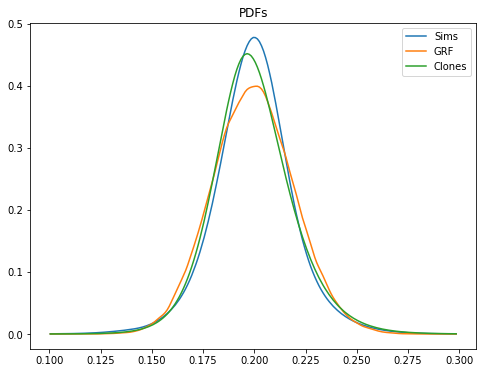

In [91]:
fig = plt.figure(figsize = (8,6))

#for idx, c in enumerate(cmap):
    #i = sorted_y_idxs[idx]
#plt.subplot(311)
plt.title('PDFs')
plt.plot(nu, all_orig_pdf.mean(axis = (0,1)), label = 'Sims')
#plt.subplot(312)
#plt.title('Clone Maps')
plt.plot(nu, all_grf_pdf.mean(axis = (0,1)), label = 'GRF')

plt.plot(nu, all_clone_pdf.mean(axis = (0,1)), label = 'Clones')

#plt.subplot(313)
#plt.title('GRF')
#plt.plot(nu, grf_pdfs.mean(axis = 0), label = 'GRF', alpha = 0.4)
#plt.plot(nu, rand_pdfs.mean(axis = 0), label = 'Random', alpha = 0.4)

plt.legend(loc='best')
#for i in xrange(3):
#    plt.subplot(3,1,i+1)
#plt.xlim([-6,6]);
#plt.yscale('log');

In [92]:
ks_statistic(all_orig_pdf.mean(axis = (0,1)), all_clone_pdf.mean(axis=(0,1)))

(0.05810615692912924, True)

In [93]:
from scipy.stats import skewtest, skew

In [94]:
skew(all_orig_pdf.mean(axis = (0,1)))

1.4488956878723926

In [95]:
skew(all_grf_pdf.mean(axis = (0,1)))

1.109555334273673

In [96]:
skew(all_clone_pdf.mean(axis = (0,1)))

1.3372913657780332

In [97]:
skew(grf_pdfs.mean(axis=0))

1.1081049619584673

In [98]:
skew(rand_pdfs.mean(axis=0))

1.1090815856375507

idea: cross correlate peak locations with embedding maps 